In [1]:
import os
import random
from shutil import copy2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [2]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)

!python --version

torch version :  2.7.1+cpu
torchvision version :  0.22.1+cpu
numpy version :  2.3.1
matplotlib version :  3.10.3
Python 3.11.4


In [3]:
data_dir = "dataset"
train_dir = os.path.join(data_dir)

print("Data directory:", train_dir)

Data directory: dataset


In [4]:
classes = os.listdir(train_dir)
classes

['Cassava___bacterial_blight',
 'Cassava___brown_streak_disease',
 'Cassava___green_mottle',
 'Cassava___healthy',
 'Cassava___mosaic_disease']

In [5]:
def sample_images(data_path, classname):
    # Gets the files in the directory
    class_dir = os.path.join(data_path, classname)
    if not os.path.exists(class_dir):
        return "Invalid directory"
    image_list = os.listdir(class_dir)
    if len(image_list) < 4:
        return "Not enough images in folder"

    # Pick four random images
    images_sample = random.sample(image_list, 4)

    # Plot them
    plt.figure(figsize=(20, 20))
    for i in range(4):
        img_loc = os.path.join(class_dir, images_sample[i])
        img = PIL.Image.open(img_loc)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")

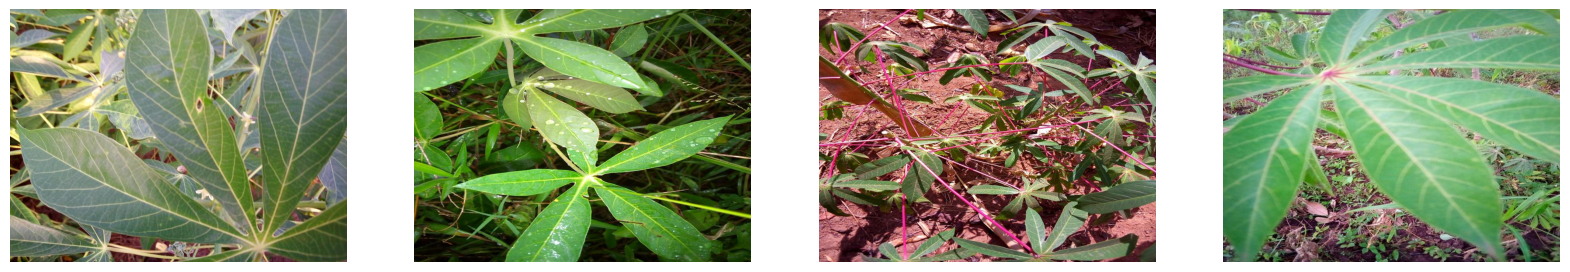

In [6]:
sample_images(train_dir, "Cassava___healthy")

Cassava___bacterial_blight


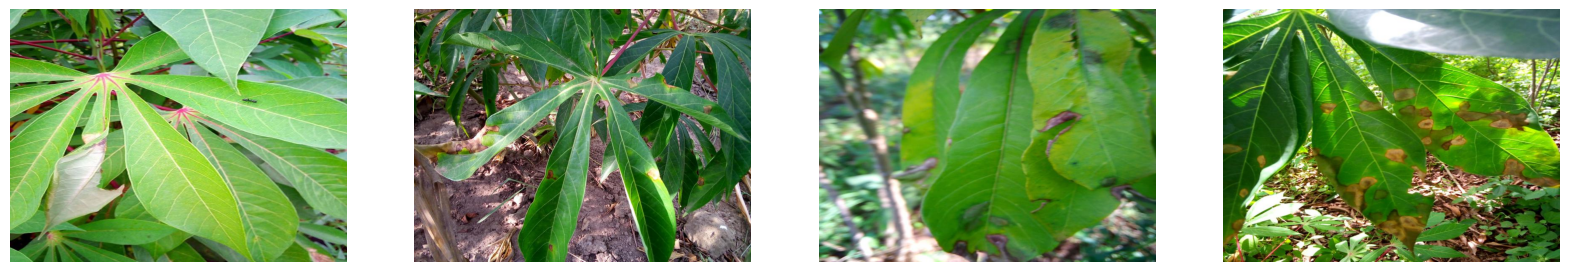

In [7]:
class_name = classes[0]
print(class_name)

sample_images(train_dir, class_name)

Cassava___brown_streak_disease


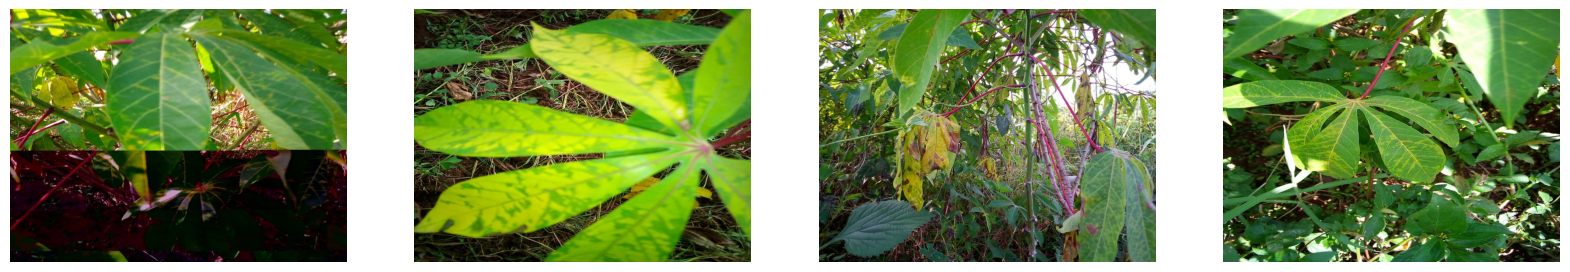

In [8]:
class_name = classes[1]
print(class_name)

sample_images(train_dir, class_name)

Cassava___green_mottle


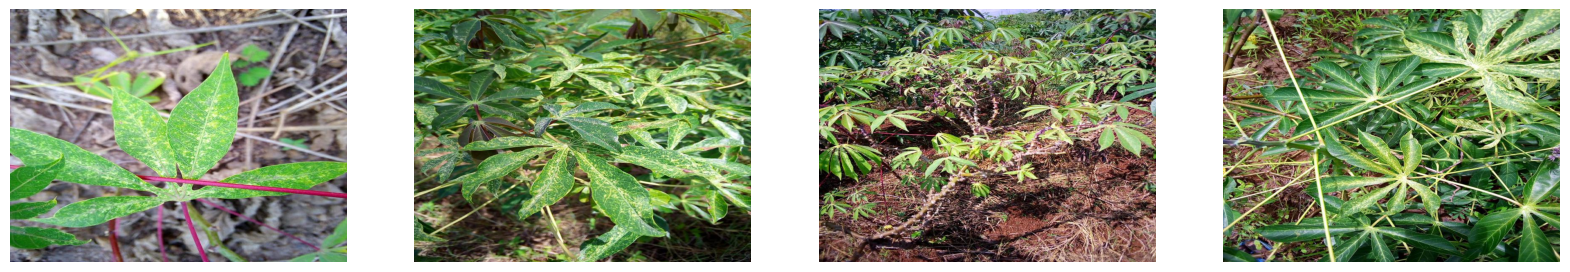

In [9]:
class_name = classes[2]
print(class_name)

sample_images(train_dir, class_name)

Cassava___mosaic_disease


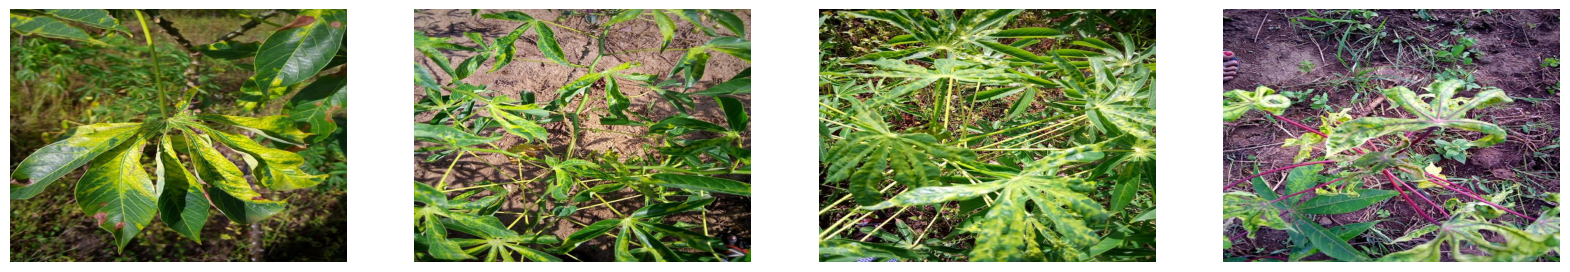

In [10]:
class_name = classes[4]
print(class_name)

sample_images(train_dir, class_name)

In [11]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [12]:
transform_basic = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [13]:
batch_size = 32
dataset = datasets.ImageFolder(root=train_dir, transform=transform_basic)
dataset_loader = DataLoader(dataset, batch_size=batch_size)

batch_shape = next(iter(dataset_loader))[0].shape
print("Getting batches of shape:", batch_shape)

Getting batches of shape: torch.Size([32, 3, 224, 224])


In [14]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [15]:
mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Computing mean and std:   0%|          | 0/215 [00:00<?, ?it/s]

Mean: tensor([0.4241, 0.4915, 0.3037])
Standard deviation: tensor([0.2222, 0.2266, 0.2152])


In [16]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

In [17]:
norm_dataset = datasets.ImageFolder(root=train_dir, transform= transform_norm)
norm_loader = DataLoader(norm_dataset, batch_size)

batch_shape = next(iter(norm_loader))[0].shape
print("Getting batches of shape:", batch_shape)

Getting batches of shape: torch.Size([32, 3, 224, 224])


In [18]:
norm_mean, norm_std = get_mean_std(norm_loader)

print(f"Mean: {norm_mean}")
print(f"Standard deviation: {norm_std}")

Computing mean and std:   0%|          | 0/215 [00:00<?, ?it/s]

Mean: tensor([ 3.5624e-07, -1.7835e-07, -2.9484e-07])
Standard deviation: tensor([1.0000, 1.0000, 1.0000])


In [19]:
train_dataset, val_dataset = random_split(norm_dataset, [0.8, 0.2])

length_train = len(train_dataset)
length_val = len(val_dataset)
length_dataset = len(norm_dataset)
percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.0% of full data
Validation data is 20.0% of full data


In [20]:
from training import class_counts

In [21]:
train_counts = class_counts(train_dataset)
train_counts

  0%|          | 0/5481 [00:00<?, ?it/s]

Cassava___bacterial_blight         854
Cassava___brown_streak_disease    1185
Cassava___green_mottle             964
Cassava___healthy                 1020
Cassava___mosaic_disease          1458
dtype: int64

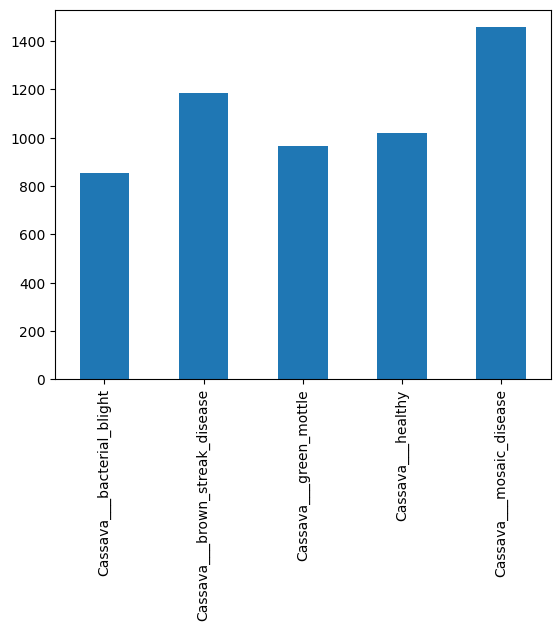

In [22]:
train_counts.plot(kind="bar");

  0%|          | 0/1370 [00:00<?, ?it/s]

<Axes: >

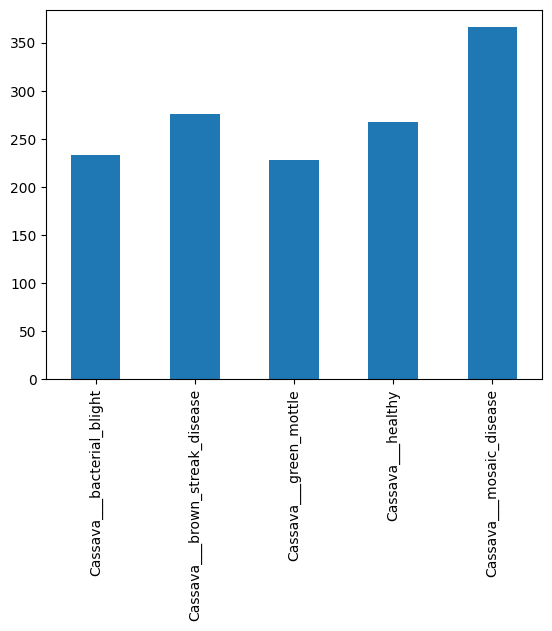

In [23]:
val_counts = class_counts(val_dataset)

# Create a bar chart from val_counts
val_counts.plot(kind='bar')

In [24]:
def undersample_dataset(dataset_dir, output_dir, target_count=None):
    """
    Undersample the dataset to have a uniform distribution across classes.

    Parameters:
    - dataset_dir: Path to the directory containing the class folders.
    - output_dir: Path to the directory where the undersampled dataset will be stored.
    - target_count: Number of instances to keep in each class. If None, the class with the least instances will set the target.
    """
    # Mapping each class to its files
    classes_files = {}
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            files = os.listdir(class_dir)
            classes_files[class_name] = files

    # Determine the minimum class size if target_count is not set
    if target_count is None:
        target_count = min(len(files) for files in classes_files.values())

    # Creating the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Perform undersampling
    for class_name, files in classes_files.items():
        print("Copying images for class", class_name)
        class_output_dir = os.path.join(output_dir, class_name)
        if not os.path.exists(class_output_dir):
            os.makedirs(class_output_dir)

        # Randomly select target_count images
        selected_files = random.sample(files, min(len(files), target_count))

        # Copy selected files to the output directory
        for file_name in tqdm(selected_files):
            src_path = os.path.join(dataset_dir, class_name, file_name)
            dst_path = os.path.join(class_output_dir, file_name)
            copy2(src_path, dst_path)

    print(f"Undersampling completed. Each class has up to {target_count} instances.")

In [26]:
output_dir = os.path.join("dataset/data_undersampled/train")
print("Output directory:", output_dir)

Output directory: dataset/data_undersampled/train


In [27]:
undersample_dataset(train_dir, output_dir)

Copying images for class Cassava___bacterial_blight


  0%|          | 0/1087 [00:00<?, ?it/s]

Copying images for class Cassava___brown_streak_disease


  0%|          | 0/1087 [00:00<?, ?it/s]

Copying images for class Cassava___green_mottle


  0%|          | 0/1087 [00:00<?, ?it/s]

Copying images for class Cassava___healthy


  0%|          | 0/1087 [00:00<?, ?it/s]

Copying images for class Cassava___mosaic_disease


  0%|          | 0/1087 [00:00<?, ?it/s]

Undersampling completed. Each class has up to 1087 instances.


In [28]:
undersampled_dataset = datasets.ImageFolder(root=output_dir, transform= transform_norm)

In [29]:
undersampled_dataset.classes

['Cassava___bacterial_blight',
 'Cassava___brown_streak_disease',
 'Cassava___green_mottle',
 'Cassava___healthy',
 'Cassava___mosaic_disease']

  0%|          | 0/5435 [00:00<?, ?it/s]

<Axes: >

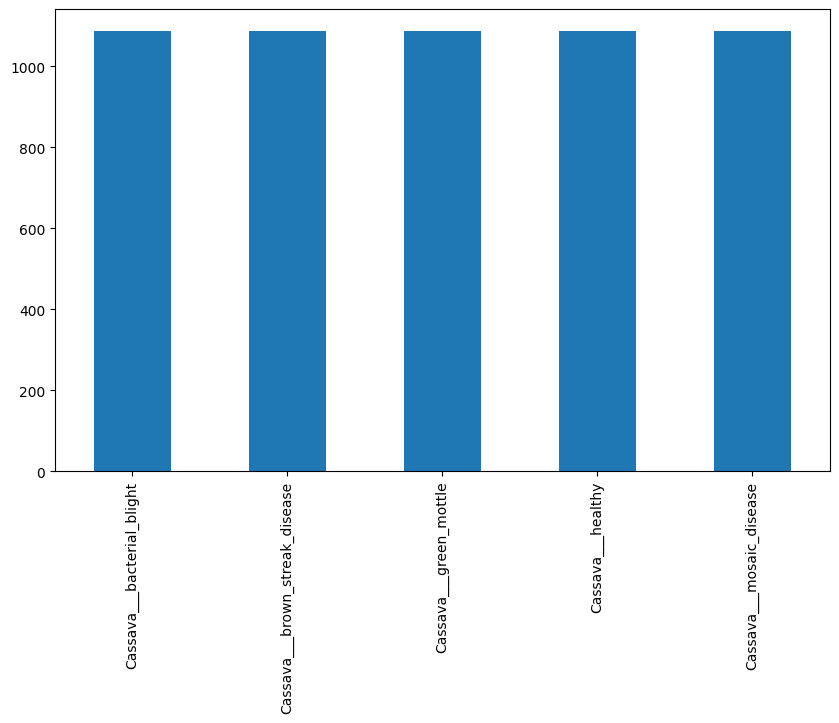

In [30]:
# Important, don't change this
fig, ax = plt.subplots(figsize=(10, 6))

under_counts = class_counts(undersampled_dataset)

# Create a bar chart from under_counts
# important, you must leave `ax=ax`
under_counts.plot(kind='bar', ax=ax)